## El sistema de cúmulos globulares de M87.

Usaremos los datos del programa 9401, "The ACS Virgo Cluster Survey", del HST, tomados en los filtros F475W y F850LP. Para ello utilizaremos SExtractor:

In [1]:
#Felipe et Al. (2016):
from astropy.io import fits

hdu1 = fits.open('hst_9401_02_acs_wfc_f475w_drz.fits')
hdu2 = fits.open('hst_9401_02_acs_wfc_f850lp_drz.fits')

sci1 = hdu1['sci']
sci2 = hdu2['sci']

exp1 = hdu1['wht']
exp2 = hdu2['wht']


sci1.writeto('sci_f475w_M87.fits', clobber=True)
sci2.writeto('sci_f850lp_M87.fits', clobber=True)

exp1.writeto('invvar_f475w_M87.fits', clobber=True)
exp2.writeto('invvar_f850lp_M87.fits', clobber=True)

In [2]:
stdout1 = !sextractor sci_f475w_M87.fits -c config_f475w_M87.sex
stdout2 = !sextractor sci_f850lp_M87.fits -c config_f850lp_M87.sex

print('F555W_N121\n', stdout1.n[-152:], '\n')
print('F814W_N121\n', stdout2.n[-152:])

F555W_N121
   Objects: detected 4479     / sextracted 2638            

> Closing files
> 
> All done (in 4.5 s: 929.7 lines/s , 582.1 detections/s) 

F814W_N121
 Objects: detected 6321     / sextracted 3089            

> Closing files
> 
> All done (in 2.9 s: 1428.4 lines/s , 1047.3 detections/s)


Considerando los valores para la corrección en la fotometría de Sirianni et Al. [(2015)](https://www.cfa.harvard.edu/twpub/Main/NextGenSpectrophotometry/Sirianni_HST_PSFs.pdf) y la [extinción](https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=m87&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES) tenemos:

In [3]:
import numpy as np

#Cargamos nuestros catalogos
_, _, _, f5m, f5me, f5ra, f5de = np.genfromtxt('M87_f475w.cat', unpack=True)
_, _, _, f8m, f8me, f8ra, f8de = np.genfromtxt('M87_f850lp.cat', unpack=True)

# Aplicamos las correcciones de la vida.
enc_energy = [0.890, 0.837]  # apcor
exc_ratio = [3.591, 1.472]  # Para elípticas
color_excess = 0.096 - 0.074

f5m += -exc_ratio[0] * color_excess + 2.5 * np.log10(enc_energy[0])
f8m += -exc_ratio[1] * color_excess + 2.5 * np.log10(enc_energy[1])

In [4]:
from astropy.coordinates import SkyCoord
from astropy import units as u

f5 = SkyCoord(f5ra*u.degree, f5de*u.degree)
f8 = SkyCoord(f8ra*u.degree, f8de*u.degree)

idxf8, idxf5, d2d, d3d = f5.search_around_sky(f8, 0.08*u.arcsec)

#Verificamos cuántas coincidencias encontró y comparamos con el tamano de los catalogos
print(idxf8.shape, idxf5.shape)
print(f5.shape, f8.shape)

print(np.unique(idxf8).shape, np.unique(idxf5).shape)



(1706,) (1706,)
(2638,) (3089,)
(1706,) (1706,)


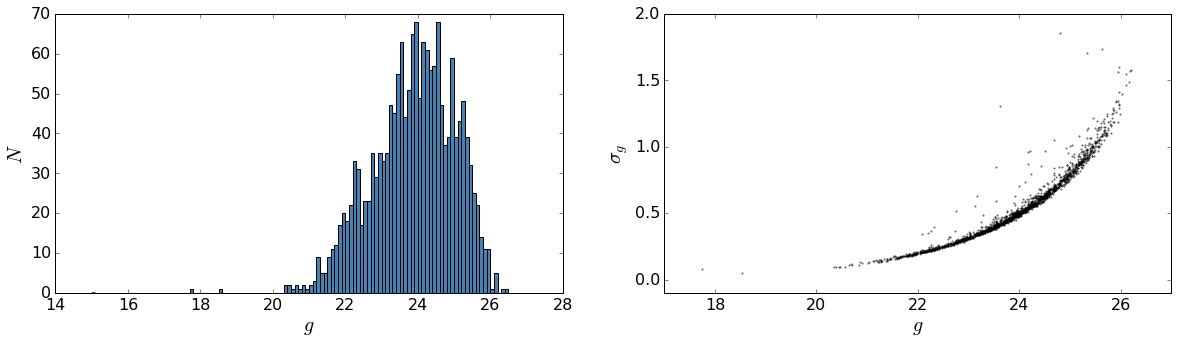

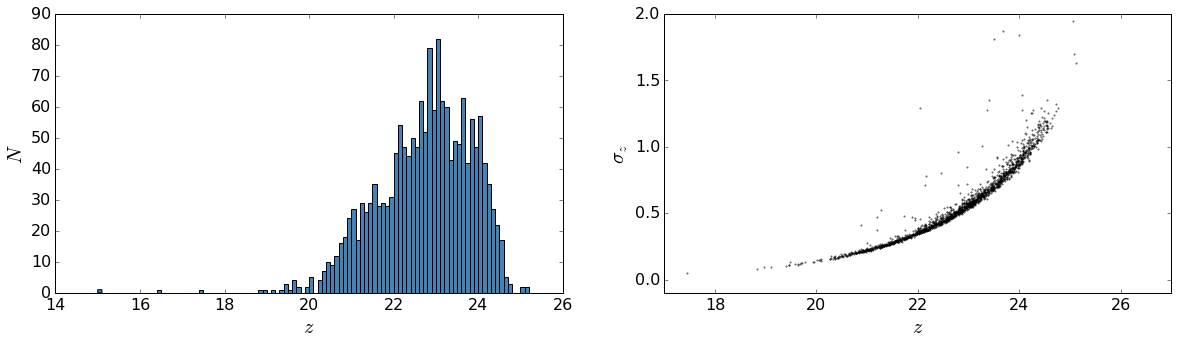

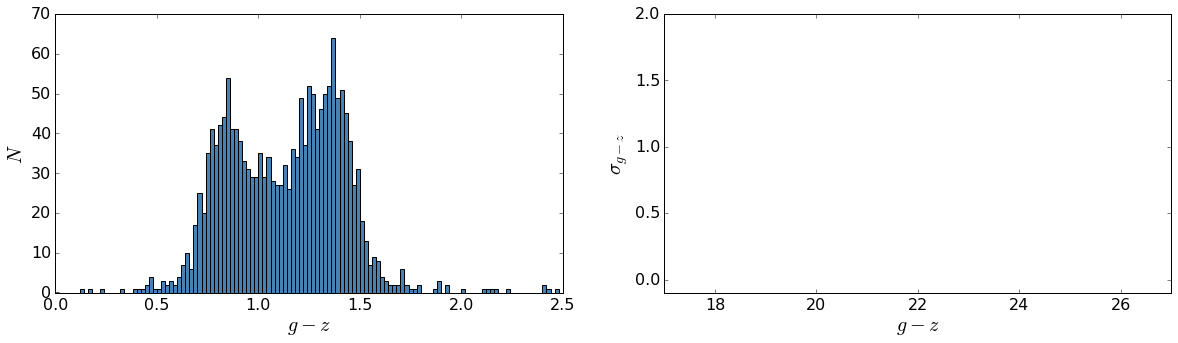

In [12]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)
%matplotlib inline



#Plot magnitudes y errores
fig, ax = plt.subplots(ncols=2, figsize=[20,5])
_ = ax[0].hist(f5m[idxf5], bins=np.arange(15,28,0.1), color='steelblue')
ax[0].set_xlabel('$g$')
ax[0].set_ylabel('$N$')

ax[1].plot(f5m[idxf5], f5me[idxf5], '.k', ms=3, alpha=.5)
ax[1].set_ylim(-.1,2)
ax[1].set_xlim(17,27)
ax[1].set_xlabel('$g$')
ax[1].set_ylabel('$\sigma_{g}$')



fig, ax = plt.subplots(ncols=2, figsize=[20,5])
_ = ax[0].hist(f8m[idxf8], bins=np.arange(15,26,0.1), color='steelblue')
ax[0].set_xlabel('$z$')
ax[0].set_ylabel('$N$')

ax[1].plot(f8m[idxf8], f8me[idxf8], '.k', ms=3, alpha=.5)
ax[1].set_ylim(-.1,2)
ax[1].set_xlim(17,27)
ax[1].set_xlabel('$z$')
ax[1].set_ylabel('$\sigma_{z}$')



fig, ax = plt.subplots(ncols=2, figsize=[20,5])
_ = ax[0].hist(f5m[idxf5]-f8m[idxf8], bins=np.arange(0,2.5,0.02), color='steelblue')
ax[0].set_xlabel('$g-z$')
ax[0].set_ylabel('$N$')

ax[1].plot(f5m[idxf5]-f8m[idxf8], f5me[idxf5]-f8me[idxf8], '.k', ms=3, alpha=.5)
ax[1].set_ylim(-.1,2)
ax[1].set_xlim(17,27)
ax[1].set_xlabel('$g-z$')
ax[1].set_ylabel('$\sigma_{g-z}$')




Podemos notar que hay dos peaks. Considerando que los cúmulos tienen la misma edad, esta forma bimodal se debe a la diferencia de metalicidad que tienen los cúmulos.

In [6]:
import scipy.optimize as op

def gaussian(z, u, sigma):
    fact1 = np.power(2 * np.pi * np.power(sigma, 2), -1 / 2)
    fact2 = np.exp(-np.power(z-u, 2) / (2 * np.power(sigma, 2)))
    return fact1 * fact2

Ahora usaremos una imagen en rayos-x de M87 del telescopio [Chandra](http://cxc.harvard.edu/cda/footprint/cdaview.html):

In [7]:
hdu3 = fits.open('acisf05827N003_cntr_img2.fits')
sci3 = hdu3['primary']
sci3.writeto('sci_xray_M87.fits', clobber=True)
stdout3 = !sextractor sci_xray_M87.fits -c config_xray_M87.sex

print('F814W_N121\n', stdout3.n[-152:])

F814W_N121
 bjects: detected 756      / sextracted 503             

> Closing files
> 
> All done (in 0.1 s: 11566.4 lines/s , 5681.6 detections/s)


In [8]:
_, xrm, xrme, xrx, xry, xrra, xrde = np.genfromtxt('M87_xray.cat', unpack=True)

#"Multiplicamos" por la unidad correspondiente
ff5 = SkyCoord(f5ra*u.degree, f5de*u.degree)
xr = SkyCoord(xrra*u.degree, xrde*u.degree)

idxxr, idxff5, d2d, d3d = ff5.search_around_sky(xr, 0.3*u.arcsec)

#Verificamos cuántas coincidencias encontró y comparamos con el tamano de los catalogos
print(idxxr.shape, idxff5.shape)
print(f5.shape, xr.shape)

print(np.unique(idxxr).shape, np.unique(idxff5).shape)


(37,) (37,)
(2638,) (503,)
(37,) (37,)


SExtractor no es lo ideal para hacer fotometría en rayos x, sin embargo se encontraron 37 match. Por lo que estas fuentes de emisión de rayos x no provienen de todos los cúmulos globulares.